In [1]:
import json
import geopandas as gpd
import os
from planet import Auth
from planet import data_filter
from datetime import datetime
from planet import Session
import pandas as pd

path_to_api_key = '/explore/nobackup/people/almullen/smallsat_augmentation/code/PL_API_KEY.txt'
path_to_shapefile = '/explore/nobackup/people/almullen/smallsat_augmentation/data/rois/YKD/YKD_ABoVE_tiles_C.shp'
path_to_tile_downloads = '/explore/nobackup/people/almullen/smallsat_augmentation/data/orders/YKD'
#read the geojson as a dictionary to feed into the Planet search
#path_to_geojson = '/explore/nobackup/people/almullen/smallsat_augmentation/data/rois/YKD/YKD_ABoVE_tiles_C.shp'
#with open(path_to_geojson) as json_file:
#    geom = json.load(json_file)

#open the geojson with geopandas and plot to make sure this is the correct region   
shapefile = gpd.read_file(path_to_shapefile)
shapefile = shapefile.to_crs('EPSG:4326')


/panfs/ccds02/nobackup/people/almullen/.conda/envs/smallsat/lib/python3.9/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_2573817/1963760096.py:2: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


<AxesSubplot:>

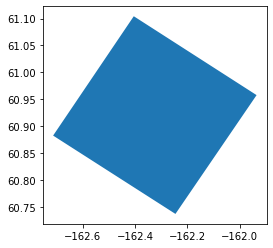

In [2]:
#tile_id='Ch010v026' #quinhagak
#tile_id= 'Ch009v024' #kwigillingok
tile_id = 'Ch013v023' #nunapitchuk

tile = shapefile.loc[shapefile['grid_id']==tile_id]
tile.plot()

In [3]:
#get json representation of tile
tile_json = json.loads(tile.to_json())
tile_json

{'type': 'FeatureCollection',
 'features': [{'id': '123',
   'type': 'Feature',
   'properties': {'grid_level': 'C',
    'grid_id': 'Ch013v023',
    'spatial_re': '5 meter (fine)',
    'ah': 0,
    'av': 0,
    'bh': 2,
    'bv': 3,
    'ch': 13,
    'cv': 23},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-162.71333164298724, 60.882400198351654],
      [-162.4048921421191, 61.104201003350205],
      [-161.93532070034559, 60.95761205595547],
      [-162.24560498374734, 60.73681937108626],
      [-162.71333164298724, 60.882400198351654]]]}}]}

In [4]:
#Authenticate Planet
with open(path_to_api_key) as f:
    pl_api_key = f.readline()
    auth = Auth.from_key(pl_api_key)
    auth.store()

In [5]:
#set up API orders data filter
sfilter = data_filter.and_filter([
    data_filter.permission_filter(),
    data_filter.date_range_filter('acquired', gt=datetime(2018, 5, 1, 1), lt=datetime(2023, 11, 1, 1)),
    data_filter.geometry_filter(tile_json),
    data_filter.asset_filter(['ortho_analytic_4b_sr', 'ortho_analytic_8b_sr']),
    data_filter.range_filter('cloud_percent', lte=20),
    data_filter.string_in_filter('instrument', ['PSB.SD', 'PS2.SD'])
])

In [8]:
#Query Planet Catalog
ids = []
async def search():
    async with Session() as sess:
        cl = sess.client('data')
        items = [i async for i in cl.search(['PSScene'], sfilter, limit=0)]
        
        print('{} results'.format(len(items)))
        for item in items:
            ids.append([item['properties']['acquired'], 
                       item['id'], 
                       item['properties']['instrument'], 
                       item['properties']['cloud_percent'], 
                       item['properties']['clear_percent'], 
                       item['properties']['clear_confidence_percent'],
                       {'geometry': item['geometry'], 'properties': {}}])
        
await search()

3808 results


In [9]:
#Create dataframe with image ids and metadata
df_ids = gpd.GeoDataFrame(ids, columns = ['time', 'id', 'instrument', 'cloud_percent', 'clear_percent', 'clear_confidence_percent', 'geometry'])
df_ids['geometry'] = gpd.GeoDataFrame.from_features(df_ids['geometry'])['geometry']
df_ids = df_ids.set_geometry('geometry')
df_ids.crs='EPSG:4326'

#Filter for growing season
df_ids['time'] = pd.to_datetime(df_ids['time'])
df_ids['year'] = df_ids['time'].dt.year
df_ids['month'] = df_ids['time'].dt.month
df_ids = df_ids.loc[(df_ids['month']>=5) & (df_ids['month']<=10)]

df_ids = df_ids.sort_values(by='time')

In [10]:
df_ids

,time,id,instrument,cloud_percent,clear_percent,clear_confidence_percent,geometry,year,month
3510,2019-06-16 22:03:23.931436+00:00,20190616_220323_93_105c,PS2.SD,19,26,67,"POLYGON ((-162.22124 61.00981, -162.33739 60.8...",2019,6
3505,2019-08-17 21:57:32.443102+00:00,20190817_215732_44_105e,PS2.SD,0,100,99,"POLYGON ((-162.48278 61.21675, -162.57069 61.0...",2019,8
3503,2019-08-17 21:57:34.507748+00:00,20190817_215734_50_105e,PS2.SD,0,100,100,"POLYGON ((-162.56121 61.08957, -162.64844 60.9...",2019,8
3504,2019-08-17 21:57:36.572919+00:00,20190817_215736_57_105e,PS2.SD,0,100,100,"POLYGON ((-162.63786 60.96214, -162.72434 60.8...",2019,8
3506,2019-08-17 21:57:38.637565+00:00,20190817_215738_63_105e,PS2.SD,0,100,99,"POLYGON ((-162.71463 60.83487, -162.80065 60.6...",2019,8
...,...,...,...,...,...,...,...,...,...
4,2023-10-26 21:57:09.610371+00:00,20231026_215709_61_2484,PSB.SD,10,88,88,"POLYGON ((-162.07724 60.92776, -162.18339 60.7...",2023,10
5,2023-10-26 21:57:11.663222+00:00,20231026_215711_66_2484,PSB.SD,1,98,89,"POLYGON ((-162.15842 60.80167, -162.26397 60.6...",2023,10
2,2023-10-31 21:13:33.015443+00:00,20231031_211333_01_2420,PSB.SD,0,100,89,"POLYGON ((-161.95021 61.01118, -162.05463 60.8...",2023,10
0,2023-10-31 21:54:33.801365+00:00,20231031_215433_80_2475,PSB.SD,5,94,89,"POLYGON ((-162.02439 61.09129, -162.12599 60.9...",2023,10


In [11]:
from planet import order_request

tools = [order_request.harmonize_tool(target_sensor='Sentinel-2'),
           order_request.clip_tool(aoi=tile_json),
           order_request.composite_tool()
          ]

In [12]:
from planet import reporting

for t in df_ids['time'].dt.date.unique():
    
    time = str(t)
    
    if not os.path.exists(os.path.join(path_to_tile_downloads, tile_id)):
        os.mkdir(os.path.join(path_to_tile_downloads, tile_id))
        
    if not os.path.exists(os.path.join(path_to_tile_downloads, tile_id, time)):
        os.mkdir(os.path.join(path_to_tile_downloads, tile_id, time))
    
    df_t = df_ids.loc[df_ids['time'].dt.date==t]

    #composite operation places last image in list on top, so sort first by cloud percent, 
    #descending, then clear confidence percent, ascending
    df_t = df_t.sort_values(by=['cloud_percent', 'clear_confidence_percent'], ascending=[False, True])

    #build request
    request = order_request.build_request(
        name='{}_{}'.format(tile_id, time),
        products=[
            order_request.product(item_ids=df_t['id'].to_list(),
                                            product_bundle='analytic_sr_udm2',
                                            item_type='PSScene')
            ],
        tools=tools
     )

    #place the request with asynchronous function
    async def main():
        async with Session() as sess:
            cl = sess.client('orders')
            with reporting.StateBar(state='creating') as bar:
                #place order
                order = await cl.create_order(request)
                
                with open(os.path.join(path_to_tile_downloads, tile_id, time, 'order_id.txt'), 'w') as file:
                    file.write(order['id'])
                with open(os.path.join(path_to_tile_downloads, tile_id, time, 'image_ids.txt'), 'w') as file:
                    file.write(str(df_t['id'].unique()))
                    
    await main()

    

00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:01 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:01 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:01 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - order  - state: creating
00:00 - or